# 1. Data Loading and Preparation:

### 1.1 Load Data

In [ ]:
import pandas as pd

import numpy as np

from datetime import datetime, timedelta

# simulating 500 customers making 5,000 separate store visits over a two-year period.


# Generate mock transaction data

np.random.seed(42)

num_transactions = 5000 # simulates 5000 separate customer visits or checkout events to a store.
num_customers = 500

products = [f'Prod_{100+i}' for i in range(20)]

start_date = datetime(2022, 1, 1)
end_date = datetime(2023, 12, 31)
date_range_days = (end_date - start_date).days

transaction_data = []


# Creating Customer Profiles
# Creates a dictionary storing mock profiles for each of the 500 customers
customer_profiles = {
    f'CUST{1000+i}': {'avg_spend': np.random.uniform(10, 200), 'frequency_factor': np.random.uniform(0.1, 1)}
    for i in range(num_customers)
}


# Simulate Transactions

# Simulates one complete visit to the store (a single checkout event).
for i in range(num_transactions): # Iterates 5,000 times to simulate 5,000 separate "transaction events."
    customer_id = f'CUST{1000 + np.random.randint(0, num_customers)}'
    transaction_date = start_date + timedelta(days=np.random.randint(0, date_range_days))
    num_items_in_transaction = np.random.randint(1, 6) # randomly determine how many unique items the customer bought on this visit (between 1 and 5 unique items).

 # Simulates the clerk scanning each item one by one and calculating its cost.
 # This is why I generate many more line items (rows in the final data) than actual transactions
    for _ in range(num_items_in_transaction): # Iterates for the number of items determined in the outer loop, creating a line item for each unique product in the transaction.
        product_id = np.random.choice(products)
        quantity = np.random.randint(1, 4)
        unit_price = np.random.uniform(5, 100) * (customer_profiles[customer_id]['avg_spend'] / 50) # Tie price to customer profile somewhat
        unit_price = round(max(1.0, unit_price), 2)


        transaction_data.append({
            'TransactionID': f'TRX{50000+i}_{_}',
            'CustomerID': customer_id,
            'TransactionDate': transaction_date.strftime('%Y-%m-%d'),
            'ProductID': product_id,
            'Quantity': quantity,
            'UnitPrice': unit_price
        })



df_transactions = pd.DataFrame(transaction_data)

df_transactions['TotalPrice'] = df_transactions['Quantity'] * df_transactions['UnitPrice']



# Save to CSV

df_transactions.to_csv('customer_transactions_mock_data.csv', index=False)
print("Mock customer transaction data generated: customer_transactions_mock_data.csv")
# print(df_transactions.head())



# --- RFM Calculation Example (to be done in the task notebook) ---

# snapshot_date = pd.to_datetime(end_date + timedelta(days=1))

# df_transactions['TransactionDate'] = pd.to_datetime(df_transactions['TransactionDate'])



# rfm = df_transactions.groupby('CustomerID').agg(

#     Recency=('TransactionDate', lambda x: (snapshot_date - x.max()).days),

#     Frequency=('TransactionID', 'count'), # Using TransactionID count for simplicity, could be unique days

#     MonetaryValue=('TotalPrice', 'sum')

# ).reset_index()

# print("\nSample RFM data (first 5 rows):")

# print(rfm)
# # print(rfm.head())

Mock customer transaction data generated: customer_transactions_mock_data_TEST.csv

Sample RFM data (first 5 rows):
    CustomerID  Recency  Frequency  MonetaryValue
0     CUST1000       10         41        6855.79
1     CUST1001       50         10        2856.43
2     CUST1002        8         25        2175.73
3     CUST1003       23         33        1085.57
4     CUST1004      135         27        6887.81
..         ...      ...        ...            ...
495   CUST1495       70         31       11320.65
496   CUST1496      129         28        2917.11
497   CUST1497       92         30        5462.50
498   CUST1498       81         27        7750.99
499   CUST1499      151         18        7521.02

[500 rows x 4 columns]


In [2]:
df_transactions.describe()

,TransactionDate,Quantity,UnitPrice,TotalPrice
count,15143,15143.000000,15143.000000,15143.000000
mean,2022-12-28 14:33:25.996169984,1.998349,103.732894,207.328918
min,2022-01-01 00:00:00,1.000000,1.220000,1.540000
25%,2022-06-27 12:00:00,1.000000,34.010000,58.740000
50%,2022-12-28 00:00:00,2.000000,76.970000,137.970000
75%,2023-07-01 00:00:00,3.000000,154.180000,285.340000
max,2023-12-30 00:00:00,3.000000,393.870000,1181.610000
std,NaN,0.818851,85.986186,203.743701


### 1.2 Clean the data (handle missing values, outliers if any).

#### Check missing values

In [5]:
import pandas as pd
df = pd.read_csv("customer_transactions_mock_data.csv")
print()
print("Missing Values per column: \n", df.isnull().sum())


Missing Values per column: 
 TransactionID          0
CustomerID             0
TransactionDate        0
ProductID              0
Quantity               0
UnitPrice              0
TotalPrice             0
Unnamed: 7         15143
Unnamed: 8         15143
Unnamed: 9         15143
Unnamed: 10        15123
dtype: int64


#### Check for Duplicates

In [6]:
duplicates = df.duplicated().sum()
print(f"Number of Duplicate rows: {duplicates}")

Number of Duplicate rows: 0


#### Check for Invalid Values

In [7]:
print(df[(df['Quantity'] <= 0) | (df['UnitPrice'] <= 0)])
print(df[(df['Quantity'] <= 0) & (df['UnitPrice'] <= 0)])
print(df[df['Quantity'] < 0])

Empty DataFrame
Columns: [TransactionID, CustomerID, TransactionDate, ProductID, Quantity, UnitPrice, TotalPrice, Unnamed: 7, Unnamed: 8, Unnamed: 9, Unnamed: 10]
Index: []
Empty DataFrame
Columns: [TransactionID, CustomerID, TransactionDate, ProductID, Quantity, UnitPrice, TotalPrice, Unnamed: 7, Unnamed: 8, Unnamed: 9, Unnamed: 10]
Index: []
Empty DataFrame
Columns: [TransactionID, CustomerID, TransactionDate, ProductID, Quantity, UnitPrice, TotalPrice, Unnamed: 7, Unnamed: 8, Unnamed: 9, Unnamed: 10]
Index: []


#### Handle Outliers
#### An outlier is a data point that differs significantly from other observations. In your sales data, an outlier could be:

#### A customer suddenly buying 50 units of a product when everyone else buys 1 or 2 (an outlier in Quantity).

#### An item being sold for $5,000 when most items are under $100 (an outlier in UnitPrice).

#### A total bill of $10,000 (an outlier in TotalPrice).

In [8]:
numeric_cols = ['Quantity', 'UnitPrice', 'TotalPrice']

for x in numeric_cols:
    Q1 = df[x].quantile(0.25)
    Q3 = df[x].quantile(0.75)
    print(f"Q1 Value of {x} is: ", Q1, " and the Q3 value is: ", Q3)
    IQR = Q3 - Q1
    print(f"IQR of column {x} is: {IQR}")
    
    lower_bound = Q1 - 1.5 * IQR
    print(f"Lower Bound of {x} is:", lower_bound)
    upper_bound = Q3 + 1.5 * IQR
    print(f"Upper Bound of {x} is: ", upper_bound)
    
    outliers = df[(df[x] < lower_bound) | (df[x] > upper_bound)]
    print(f"{x}: {len(outliers)} outliers detected")
    print()


# Q1 (First Quartile): The point where 25% of the data falls below it.

# Q3 (Third Quartile): The point where 75% of the data falls below it.

Q1 Value of Quantity is:  1.0  and the Q3 value is:  3.0
IQR of column Quantity is: 2.0
Lower Bound of Quantity is: -2.0
Upper Bound of Quantity is:  6.0
Quantity: 0 outliers detected

Q1 Value of UnitPrice is:  34.010000000000005  and the Q3 value is:  154.18
IQR of column UnitPrice is: 120.17
Lower Bound of UnitPrice is: -146.245
Upper Bound of UnitPrice is:  334.435
UnitPrice: 205 outliers detected

Q1 Value of TotalPrice is:  58.74  and the Q3 value is:  285.34000000000003
IQR of column TotalPrice is: 226.60000000000002
Lower Bound of TotalPrice is: -281.16
Upper Bound of TotalPrice is:  625.24
TotalPrice: 839 outliers detected



### 1.3 Convert date columns to datetime objects.

In [54]:
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15143 entries, 0 to 15142
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   TransactionID    15143 non-null  object        
 1   CustomerID       15143 non-null  object        
 2   TransactionDate  15143 non-null  datetime64[ns]
 3   ProductID        15143 non-null  object        
 4   Quantity         15143 non-null  int64         
 5   UnitPrice        15143 non-null  float64       
 6   TotalPrice       15143 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 828.3+ KB


# 2. RFM Analysis (Recency, Frequency, Monetary Value)
### Recency (How recently they purchased)
#### Lower Recency → more recent purchase → more engaged customer.
### Frequency (How often they purchased)
#### Higher frequency → more loyal / returning customers.
### Monetary Value (How much they spent)
#### Higher monetary value → higher value customers.

In [ ]:
import pandas as pd
from datetime import timedelta

df = pd.read_csv("customer_transactions_mock_data.csv")

df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])

snapshot_date = df['TransactionDate'].max() + timedelta(days=1) # calculates the day immediately following the last transaction recorded in the dataset.

rfm = df.groupby('CustomerID').agg(
    Recency = ('TransactionDate', lambda x: (snapshot_date - x.max()).days), # This calculates the difference in days between the snapshot_date and the customer's most recent transaction date (x.max())
    Frequency = ('TransactionID', 'nunique'),
    MonetaryValue = ('TotalPrice', 'sum')
).reset_index()

print(rfm)

print(rfm.describe())

rfm.to_csv("RFM_data.csv", index = False)

    CustomerID  Recency  Frequency  MonetaryValue
0     CUST1000        9         41        6855.79
1     CUST1001       49         10        2856.43
2     CUST1002        7         25        2175.73
3     CUST1003       22         33        1085.57
4     CUST1004      134         27        6887.81
..         ...      ...        ...            ...
495   CUST1495       69         31       11320.65
496   CUST1496      128         28        2917.11
497   CUST1497       91         30        5462.50
498   CUST1498       80         27        7750.99
499   CUST1499      150         18        7521.02

[500 rows x 4 columns]
          Recency   Frequency  MonetaryValue
count  500.000000  500.000000       500.0000
mean    71.310000   30.286000      6279.1636
std     65.035075   10.224543      4430.0027
min      1.000000    4.000000       377.0000
25%     22.000000   23.000000      2579.4425
50%     54.000000   30.000000      5292.9750
75%    105.250000   37.000000      9319.3500
max    500.00000

In [9]:
df = pd.read_csv("RFM_data.csv")
print(df.duplicated().sum())

print(df.isnull().sum())


0
CustomerID       0
Recency          0
Frequency        0
MonetaryValue    0
dtype: int64


In [8]:
df.describe()

,Quantity,UnitPrice,TotalPrice
count,15143.000000,15143.000000,15143.000000
mean,1.998349,103.732894,207.328918
std,0.818851,85.986186,203.743701
min,1.000000,1.220000,1.540000
25%,1.000000,34.010000,58.740000
50%,2.000000,76.970000,137.970000
75%,3.000000,154.180000,285.340000
max,3.000000,393.870000,1181.610000


                Recency  Frequency  MonetaryValue
Recency        1.000000  -0.222024      -0.131931
Frequency     -0.222024   1.000000       0.479246
MonetaryValue -0.131931   0.479246       1.000000


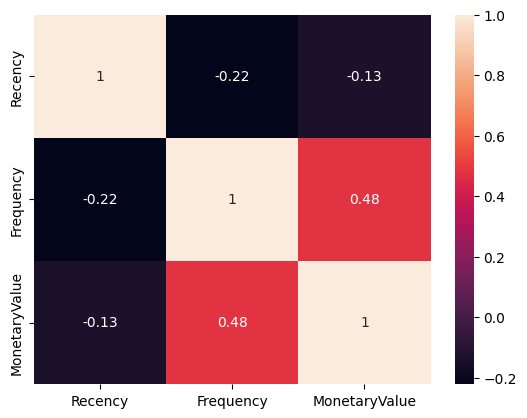

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

rfm_corr = df[['Recency', 'Frequency', 'MonetaryValue']].corr()

print(rfm_corr)

sns.heatmap(rfm_corr, annot = True)

plt.show()

# 3. Exploratory Data Analysis and Feature Scaling

### 3.1 - Analyze Distributions

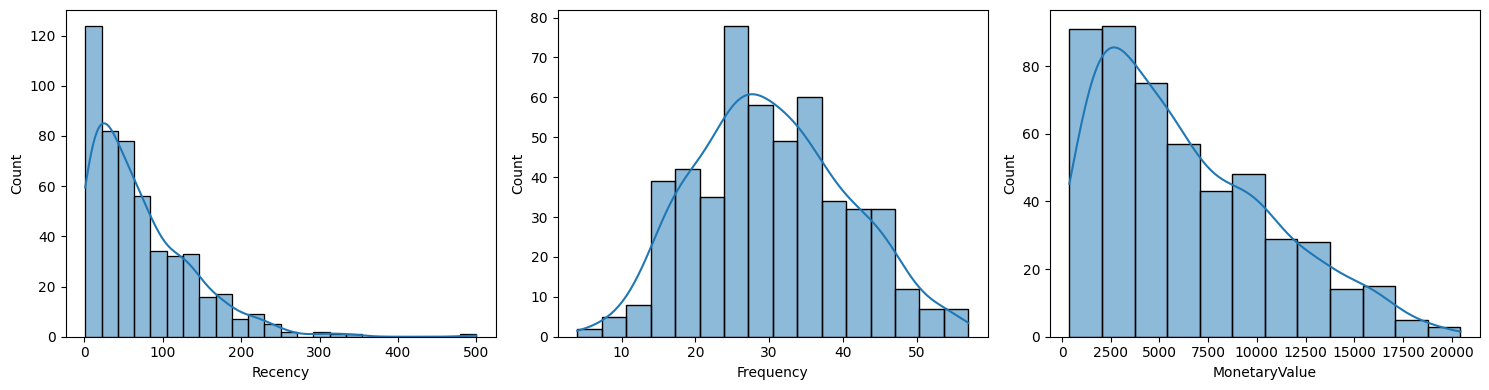

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 3, figsize = (15,4))

for ax, col in zip(axes, ['Recency', 'Frequency', 'MonetaryValue']):
    sns.histplot(df[col], kde = True, ax = ax)
    x.set_title(f"{col} Distribution")
plt.tight_layout()

plt.show()

# y axis pe jo count hai, that represents no of customers


### 3.2 - Apply Log Transformation (Reduce Skewness)

#### Log transformation reduces the impact of extreme values (outliers), helping form more meaningful and balanced clusters.

#### It brings the feature distributions closer to normal (bell-shaped), which is ideal for most ML models.

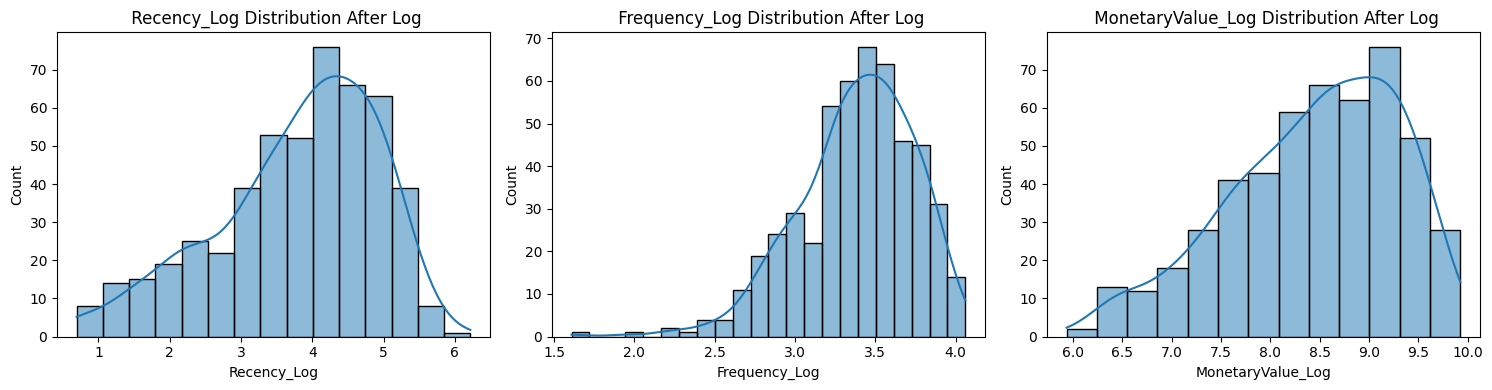

Text(0.5, 0.98, 'Applying Log Transformation')

<Figure size 640x480 with 0 Axes>

In [ ]:
import numpy as np

df_rfm = pd.read_csv("RFM_data.csv")

df_rfm['Recency_Log'] = np.log1p(df_rfm['Recency'])
df_rfm['Frequency_Log'] = np.log1p(df_rfm['Frequency'])
df_rfm['MonetaryValue_Log'] = np.log1p(df_rfm['MonetaryValue'])

# np.log1p(x) = ln(1 + x)

df_rfm.to_csv("RFM_Data_LogTransformed.csv")

fig, axes = plt.subplots(1,3,figsize = (15,4))

for ax, col in zip(axes, ['Recency_Log', 'Frequency_Log', 'MonetaryValue_Log']):
    sns.histplot(df_rfm[col], kde = True, ax = ax)
    ax.set_title(f" {col} Distribution After Log")

plt.tight_layout()
plt.show()
# plt.suptitle("Applying Log Transformation")

### 3.3 - Scale the features (e.g., using StandardScaler or MinMaxScaler) as clustering algorithms are sensitive to feature scales

#### ML Models perform better or converge faster when features are on a similar scale. Features with large differences in magnitude can unfairly dominate the objective function, biasing the model.

#### This transformation is essential in the real world because it levels the playing field for all features, preventing high-magnitude values from unfairly hijacking the model's learning process

In [33]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

df_rfm = pd.read_csv("RFM_Data_LogTransformed.csv")

scaler = StandardScaler()

rfm_scaled = scaler.fit_transform(df_rfm[['Recency_Log', 'Frequency_Log', 'MonetaryValue_Log']])

df_rfm_log_scaled = pd.DataFrame(rfm_scaled, columns= ['Recency_Log_Scaled', 'Frequency_Log_Scaled', 'MonetaryValue_Log_Scaled'])

df_rfm_log_scaled_final = pd.concat([df_rfm, df_rfm_log_scaled], axis = 1)

df_rfm_log_scaled_final.to_csv("RFM_Data_LogTransformed_Scaled.csv")

df_rfm_log_scaled

,Recency_Log_Scaled,Frequency_Log_Scaled,MonetaryValue_Log_Scaled
0,-1.311601,0.980667,0.458701
1,0.107585,-2.729292,-0.562686
2,-1.508367,-0.347315,-0.880192
3,-0.577150,0.395533,-1.690935
4,0.983425,-0.142103,0.464138
...,...,...,...
495,0.404283,0.227658,1.043864
496,0.943337,-0.044932,-0.538166
497,0.645271,0.139743,0.193645
498,0.532984,-0.142103,0.601889


In [58]:
hannan = pd.read_csv("RFM_Data_LogTransformed_Scaled.csv")
print(hannan[['Recency_Log_Scaled', 'Frequency_Log_Scaled', 'MonetaryValue_Log_Scaled']].isnull().sum())
print(hannan[['Recency_Log_Scaled', 'Frequency_Log_Scaled', 'MonetaryValue_Log_Scaled']].duplicated().sum())

Recency_Log_Scaled          0
Frequency_Log_Scaled        0
MonetaryValue_Log_Scaled    0
dtype: int64
0


In [98]:
print(hannan[['Recency_Log_Scaled', 'Frequency_Log_Scaled', 'MonetaryValue_Log_Scaled']].describe())

       Recency_Log_Scaled  Frequency_Log_Scaled  MonetaryValue_Log_Scaled
count        5.000000e+02          5.000000e+02              5.000000e+02
mean        -2.000000e-11          4.599999e-11             -2.000000e-11
std          1.001002e+00          1.001002e+00              1.001002e+00
min         -2.730787e+00         -4.912603e+00             -2.923026e+00
25%         -5.771500e-01         -5.689605e-01             -6.816637e-01
50%          1.916289e-01          1.397427e-01              1.568647e-01
75%          7.722465e-01          7.035270e-01              8.168864e-01
max          2.139744e+00          1.874457e+00              1.734055e+00


In [ ]:
cols = hannan[['Recency_Log_Scaled', 'Frequency_Log_Scaled', 'MonetaryValue_Log_Scaled']]
stats = cols.agg(['min', 'max', 'mean', 'median', 'std'])
stats.to_csv("SummaryStatsLogScaled.csv") # previously Hannaneecheeya.pdf

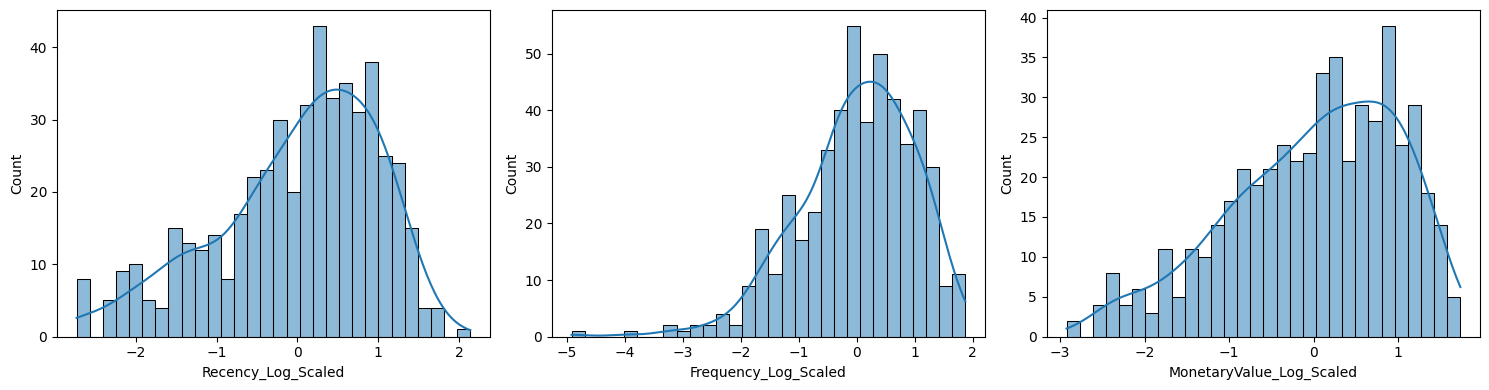

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns

cols = ['Recency_Log_Scaled', 'Frequency_Log_Scaled', 'MonetaryValue_Log_Scaled']
plt.figure(figsize=(15,4))

for x, y in enumerate(cols):
    plt.subplot(1,3,x+1)
    sns.histplot(hannan[y], kde = True, bins = 30)

plt.tight_layout()
plt.show()

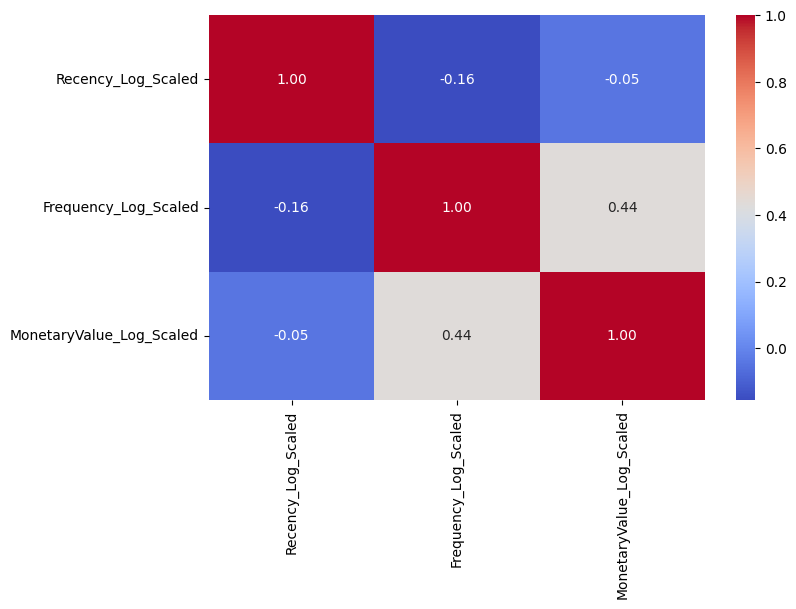

In [85]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))

sns.heatmap(hannan[['Recency_Log_Scaled', 'Frequency_Log_Scaled', 'MonetaryValue_Log_Scaled']].corr(),
annot = True, fmt = ".2f", cmap='coolwarm')

plt.show()

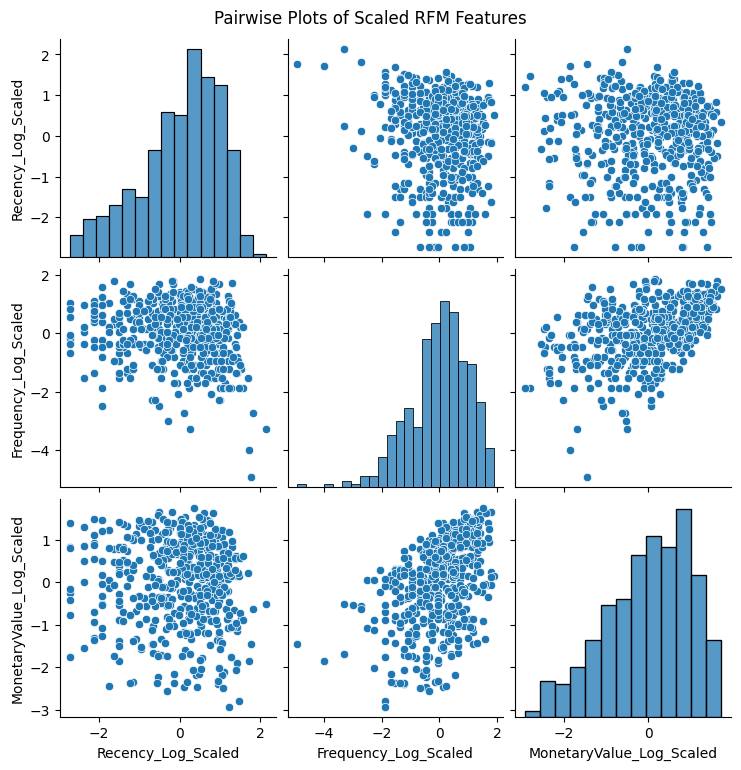

In [89]:
sns.pairplot(hannan[['Recency_Log_Scaled', 'Frequency_Log_Scaled', 'MonetaryValue_Log_Scaled']])
plt.suptitle("Pairwise Plots of Scaled RFM Features", y = 1.02)
plt.show()

c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


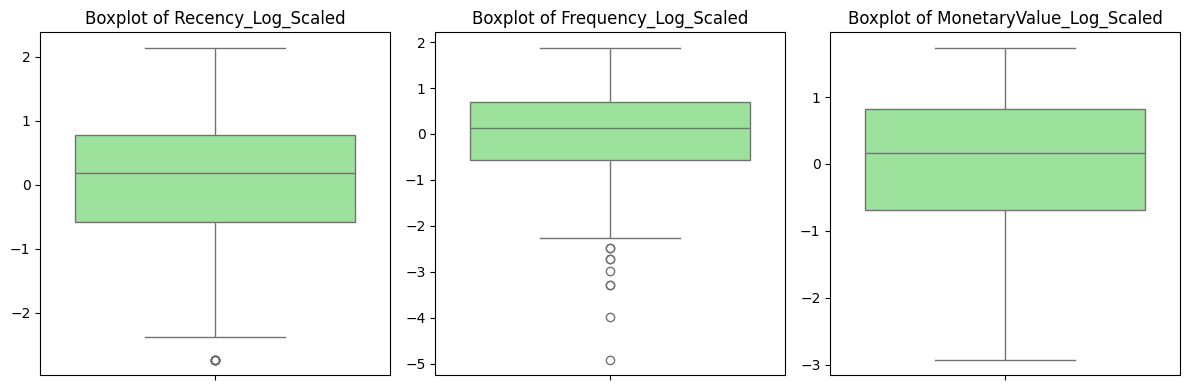

In [92]:
plt.figure(figsize=(12, 4))

for i, col in enumerate(cols):
    plt.subplot(1, 3, i+1)
    sns.boxplot(y=hannan[col], color='lightgreen')
    plt.title(f'Boxplot of {col}')
    plt.ylabel('')
    
plt.tight_layout()
plt.show()


# 4. Clustering - K-Means, Hierarchical Clustering, DBSCAN

### K-Means Clustering

Data Shape: (500, 3)

Sample Data:
    Recency_Log_Scaled  Frequency_Log_Scaled  MonetaryValue_Log_Scaled
0           -1.311601              0.980667                  0.458701
1            0.107585             -2.729292                 -0.562686
2           -1.508367             -0.347315                 -0.880192
3           -0.577150              0.395533                 -1.690935
4            0.983425             -0.142103                  0.464138

The value of WCSS score for k = 2 is: [1019.1784344400421]
The value of WCSS score for k = 3 is: [1019.1784344400421, 761.1520576579288]
The value of WCSS score for k = 4 is: [1019.1784344400421, 761.1520576579288, 643.9882743673479]
The value of WCSS score for k = 5 is: [1019.1784344400421, 761.1520576579288, 643.9882743673479, 555.0212503164171]
The value of WCSS score for k = 6 is: [1019.1784344400421, 761.1520576579288, 643.9882743673479, 555.0212503164171, 486.62734237346115]
The value of WCSS score for k = 7 is: [1019.1784344400421

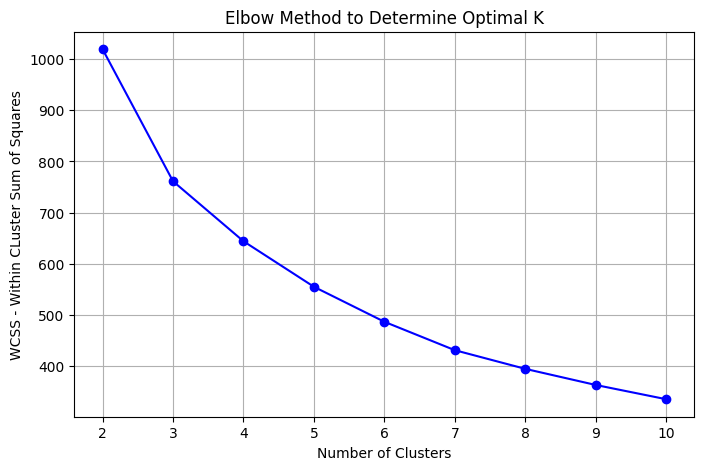

The value of Silhouette Score for k = 2 is: [0.2978940646634863]
The value of Silhouette Score for k = 3 is: [0.2978940646634863, 0.3125404872222474]
The value of Silhouette Score for k = 4 is: [0.2978940646634863, 0.3125404872222474, 0.3036503561422596]
The value of Silhouette Score for k = 5 is: [0.2978940646634863, 0.3125404872222474, 0.3036503561422596, 0.261004441625803]
The value of Silhouette Score for k = 6 is: [0.2978940646634863, 0.3125404872222474, 0.3036503561422596, 0.261004441625803, 0.25957077455702426]
The value of Silhouette Score for k = 7 is: [0.2978940646634863, 0.3125404872222474, 0.3036503561422596, 0.261004441625803, 0.25957077455702426, 0.2682251517436623]
The value of Silhouette Score for k = 8 is: [0.2978940646634863, 0.3125404872222474, 0.3036503561422596, 0.261004441625803, 0.25957077455702426, 0.2682251517436623, 0.2706806464303547]
The value of Silhouette Score for k = 9 is: [0.2978940646634863, 0.3125404872222474, 0.3036503561422596, 0.261004441625803, 0.

C:\Users\hp\AppData\Local\Temp\ipykernel_1252\1598286466.py:102: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = 'Cluster', data = df_KM, palette = 'viridis')
c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\categorical.py:1273: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the grouping

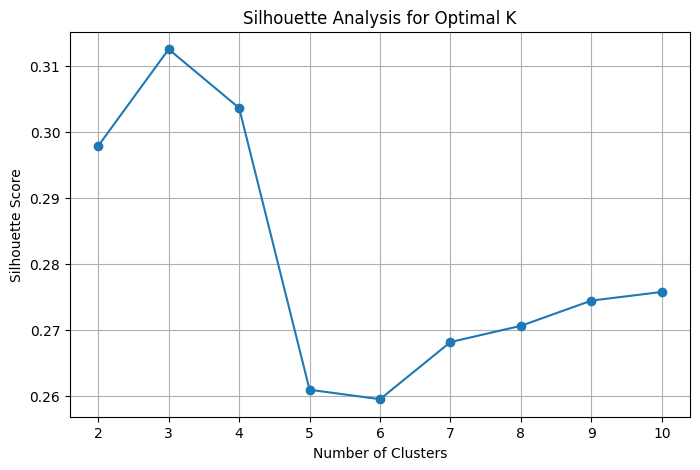

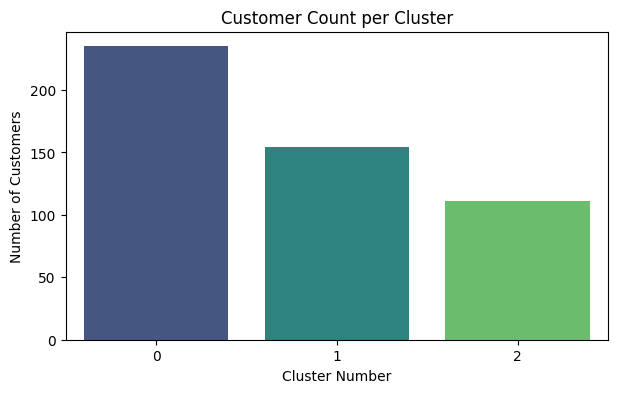

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

df_KM = pd.read_impocsv("RFM_Data_LogTransformed_Scaled.csv")

columns = df_KM[['Recency_Log_Scaled', 'Frequency_Log_Scaled', 'MonetaryValue_Log_Scaled']]

print("Data Shape:", columns.shape)
print("\nSample Data:\n", columns.head())
print()

# ─────────────────────────────────────────────
# Step 2: Determine Optimal Number of Clusters (Elbow Method)
# ─────────────────────────────────────────────

# The code's purpose is to run the K-Means algorithm for a range of different K values (from 2 to 10) and then evaluate how good or neat the resulting clusters are using a metric called WCSS.
# The core goal is to test how neat the customer groups are when the data is split into 2, 3, 4, up to 10 clusters.
wcss = [] # Within Cluster Sum of Squares. 
 '''
 WCSS is the Mess/Disorder: WCSS measures the total distance between every single brick and the center of its bin.
 If all the bricks in a bin are very close to the center (a very neat, organized bin), the WCSS is low.
 If the bricks are scattered all over the bin, far from the center (a messy, poor group), the WCSS is high.
 '''
K = range(2,11)

for x in K:
    kmeans = KMeans(n_clusters=x, random_state=42, n_init=10)
    # n_init=10: Don't just try sorting once; try it 10 different times with different starting positions for the bin centers, and only keep the best, neatest result."
    kmeans.fit(columns) # The algorithm looks at the 500 customers and assigns each one to the closest of the $k$ cluster centers
    wcss.append(kmeans.inertia_)
    # calculates the WCSS (also known as the inertia) for the fitted model and appends it to the wcss list. 
    # It calculates the Within-Cluster Sum of Squares (WCSS), which is the sum of squared distances of all 500 customers to the center of their assigned group
    print(f"The value of WCSS score for k = {x} is:", wcss)

plt.figure(figsize= (8,5))
plt.plot(K,wcss, 'o-', color = 'blue')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS - Within CLuster Sum of Squares')
plt.title("Elbow Method to Determine Optimal K")
plt.grid(True)
plt.show()


# ─────────────────────────────────────────────
# Step 3: Determine Optimal Number of Clusters using Silhouette Analysis
# ─────────────────────────────────────────────

# The Silhouette Score ranges from -1 (very bad grouping) to +1 (excellent, distinct grouping)

# The Silhouette Score measures how similar a data point is to its own cluster compared to other clusters.
# The goal is to choose the k that produces the highest score, which indicates the best-defined and most well-separated clusters

# The Silhouette Score measures two things for every single customer:
# > Cohesion: How close the customer is to other customers in their own group.
# > Separation: How far the customer is from customers in the next nearest group.

silhouette_scores = []

for x in K:
    kmeans = KMeans(n_clusters=x, random_state=42, n_init=10)
    labels = kmeans.fit_predict(columns) # The model assigns each of the 500 customers a cluster label (e.g., 'Group 1', 'Group 2', etc.)
    score = silhouette_score(columns, labels)
    silhouette_scores.append(score)
    print(f"The value of Silhouette Score for k = {x} is:", silhouette_scores)


plt.figure(figsize=(8,5))
plt.plot(K, silhouette_scores, 'o-')
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Analysis for Optimal K")
plt.grid(True)



# _____________________________________
# Step 4: Apply K-Means with the Optimal K
# ____________________________________


optimal_k = 3
kmeans_apply = KMeans(n_clusters = optimal_k, random_state=42, n_init = 10)
df_KM['Cluster'] = kmeans_apply.fit_predict(columns)
df_KM.to_csv("RFM_Data_LogTransformed_Scaled_KMeans.CSV")



# _____________________________________
# Step 5: Analyze Cluster Characteristics
# ____________________________________

cluster_summary = df_KM.groupby('Cluster')[['Recency', 'Frequency', 'MonetaryValue']].mean().round(2)
cluster_summary['Count'] = df_KM['Cluster'].value_counts()
print("\nCluster Summary:\n")
print(cluster_summary)


# _____________________________________
# Step 6: Visualize the Clusters
# ____________________________________

plt.figure(figsize=(7,4))
sns.countplot(x = 'Cluster', data = df_KM, palette = 'viridis')
plt.title("Customer Count per Cluster")
plt.xlabel("Cluster Number")
plt.ylabel("Number of Customers")
plt.show()

### Hierarchical Clustering

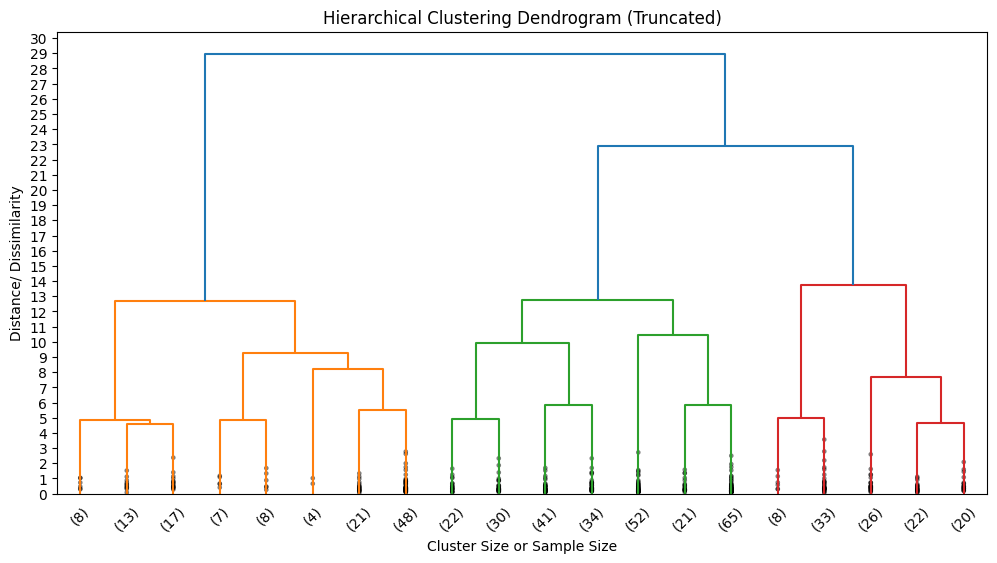

The Summary of Hierarchical Clustering is as follows: 

            Recency  Frequency  MonetaryValue  Count
Cluster_HC                                          
1            101.04      18.21        2955.07    126
2             82.42      34.68        7520.35    265
3             10.12      30.93        2073.01     41
4              9.82      35.16       10137.60     68


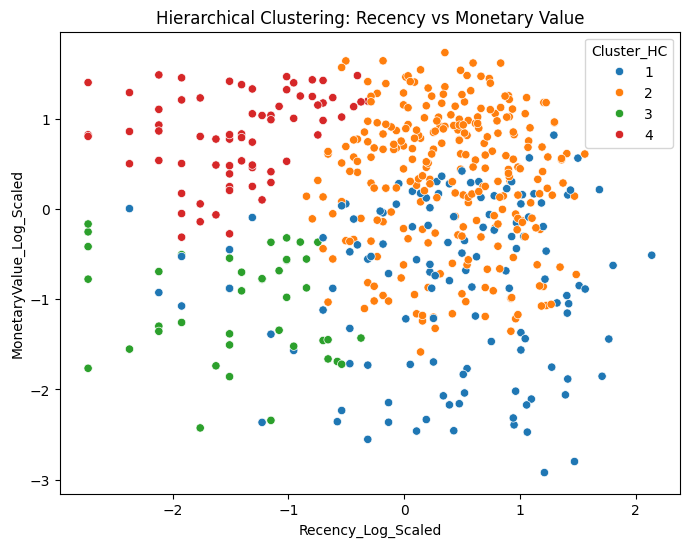

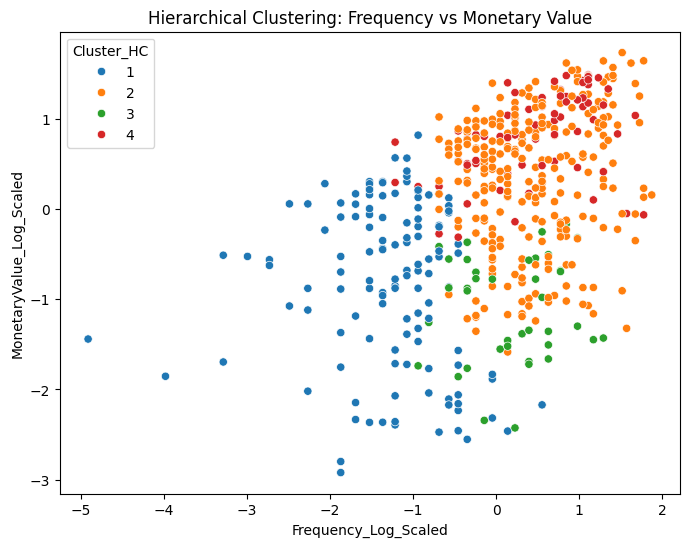

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

df_hc = pd.read_csv("RFM_Data_LogTransformed_Scaled.csv")

columns_hc = df_hc[['Recency_Log_Scaled', 'Frequency_Log_Scaled', 'MonetaryValue_Log_Scaled']]

# --------------------------------------------
#Step 2 = Create Linkage Matrix for Dendrogram
# --------------------------------------------

lnkg = linkage(columns_hc, method = 'ward')

"""
The primary purpose of this line of code is to calculate the cluster distances and merging sequence necessary to build a dendrogram
The variable lnkg is the Linkage Matrix (an array that encodes the hierarchical cluster structure.)
It's not the final groups themselves, but a detailed instruction manual or recipe for creating those groups.
It records:
> Which two customers/groups were merged.
> The distance (or "dissimilarity") between them when they were merged.
> How many original customers are in the resulting new group

Ward's method (or Ward's minimum variance method) is an agglomerative clustering method that finds the pair of clusters that leads to the minimum increase in the total within-cluster variance after merging. 
It tends to produce clusters of roughly equal size.

"""

plt.figure(figsize=(12,6))

dendrogram(lnkg, truncate_mode='lastp', p = 20, leaf_rotation= 45, leaf_font_size=10, show_contracted=True)
# p = 20 means The p=20 parameter means the dendrogram is showing the 20 largest clusters before they were merged into fewer, larger groups
plt.title("Hierarchical Clustering Dendrogram (Truncated)")
plt.xlabel("Cluster Size or Sample Size")
plt.ylabel("Distance/ Dissimilarity")
plt.yticks(range(0,31,1))
plt.show()

"""
Choosing the Cut-off: 
You typically look for a height on the vertical axis where a significant gap or jump exists between one merger and the next.
This gap suggests that merging past this point is joining two quite dissimilar groups.
"""


'''
_______________________________________

Step 3: Deciding the number of clusters
_______________________________________
'''

num_clusters = 4 # based on the dendrogram
df_hc['Cluster_HC'] = fcluster(lnkg, num_clusters, criterion='maxclust')
df_hc.to_csv("RFM_Data_LogTransformed_Scaled_HC_4.csv")


hc_summary = df_hc.groupby('Cluster_HC')[['Recency', 'Frequency', 'MonetaryValue']].mean().round(2)
hc_summary['Count'] = df_hc['Cluster_HC'].value_counts()
print("The Summary of Hierarchical Clustering is as follows: \n")
print(hc_summary)


# ─────────────────────────────────────────────
# Step 5: Visualize Clusters in 2D Space
# ─────────────────────────────────────────────
plt.figure(figsize=(8,6))
sns.scatterplot(
    x='Recency_Log_Scaled', 
    y='MonetaryValue_Log_Scaled', 
    hue='Cluster_HC', 
    data=df_hc, 
    palette='tab10'
)
plt.title('Hierarchical Clustering: Recency vs Monetary Value')
plt.show()

plt.figure(figsize=(8,6))
sns.scatterplot(
    x='Frequency_Log_Scaled', 
    y='MonetaryValue_Log_Scaled', 
    hue='Cluster_HC', 
    data=df_hc, 
    palette='tab10'
)
plt.title('Hierarchical Clustering: Frequency vs Monetary Value')
plt.show()



### DBSCAN

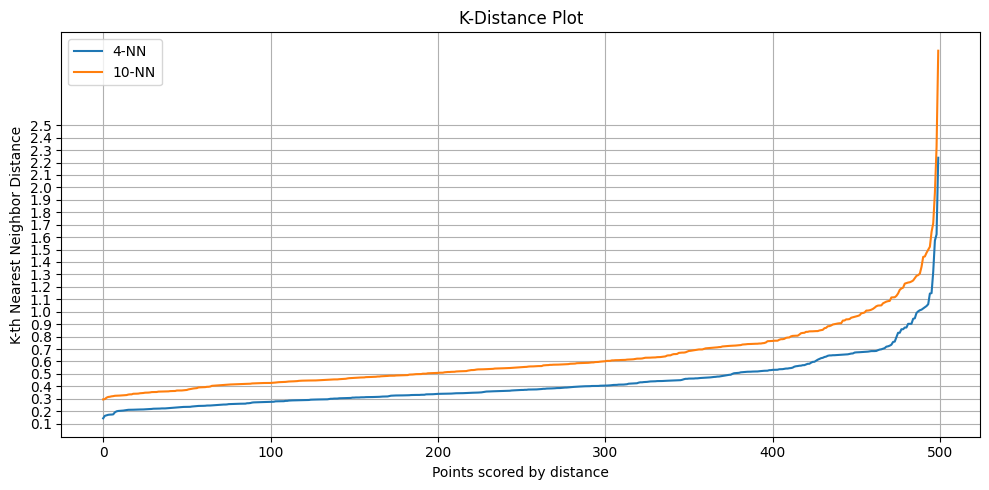


 Selected DBSCAN candidate:
eps                         0.600000
min_samples                 6.000000
no_of_clusters              2.000000
dbscan                    -37.000000
noise                      49.000000
percentage_of_noise         9.800000
silhouette                  0.300549
calinski_harabasz_score    36.571030
davies_bouldin_score        0.758531
Name: 12, dtype: float64

The chosen epsilon value is: 0.6 and the chosen min samples value is: 6

Final DBSCAN fit: eps=0.6.min_samples =6
Number of clusters (excluding noise): 2
Noise points: 49 (9.80%)

DBSCAN cluster profile (count, mean, median):

               Recency         Frequency        MonetaryValue         
                 count    mean     count   mean         count     mean
Cluster_DBSCAN                                                        
-1                  49   61.96        49  22.69            49  2181.78
 0                 439   71.46       439  31.37           439  6888.60
 1                  12  104.08

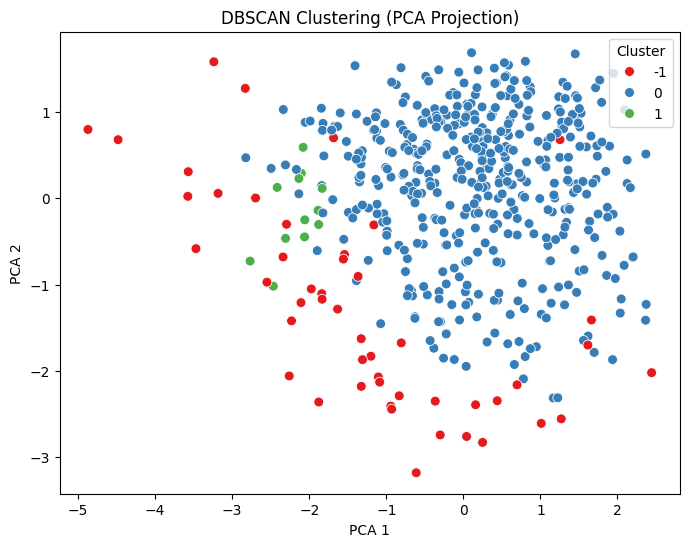

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# ____________________________
# Step 0: Load Scaled RFM Data
# ____________________________

file = pd.read_csv("RFM_Data_LogTransformed_Scaled.csv")
columns = file[['Recency_Log_Scaled', 'Frequency_Log_Scaled', 'MonetaryValue_Log_Scaled']].values

# ________________________________________
# Step 1: Find Epsilon Value using K-distance Plot
# ________________________________________

neighbors = [4,10]
plt.figure(figsize=(10,5))
for x in neighbors:
    nbrs = NearestNeighbors(n_neighbors=x).fit(columns)
    distances, indices = nbrs.kneighbors(columns)
    k_distances = np.sort(distances[:, -1])
    plt.plot(k_distances, label=f"{x}-NN")

plt.xlabel("Points scored by distance")
plt.ylabel("K-th Nearest Neighbor Distance")
plt.title("K-Distance Plot")
y_ticks = np.arange(0.1, 2.6, 0.1)
plt.yticks(y_ticks)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


#Graph shows that optimum Epsilon Value would be 0.5,0.6 or 0.7

# __________________________________________________________________________________________
# Step 2: Find the best combination of two epsilon and minimum candidates inside the cluster
# __________________________________________________________________________________________

epsilon_values = np.linspace(0.5, 0.7, 5) # will give me [0.50, 0.55, 0.60, 0.65, 0.70]
min_candidates = [4,5,6,7,8]
results = []

for x in epsilon_values:  # runs 5 times
    for y in min_candidates:  # runs 5 times for each outer loop
        # The code executes the DBSCAN algorithm 5 x 5 = 25 times, once for each combination
        dbscan = DBSCAN(eps = x, min_samples = y, metric = 'euclidean')
        dbscan_apply = dbscan.fit_predict(columns)
        dbscan_apply_2 = np.sum(dbscan_apply)
        no_of_clusters = len(set(dbscan_apply)) - (1 if -1 in dbscan_apply else 0)
        noise = np.sum(dbscan_apply == -1)
        percentage_of_noise = 100 * noise / len(dbscan_apply)

        # Judging the Cluster Quality
        if no_of_clusters >= 2:
            ignore_noise_mask = dbscan_apply != -1
            sil = silhouette_score(columns[ignore_noise_mask], dbscan_apply[ignore_noise_mask])
            # This is the Clarity Score.
            # It measures how well-separated the clusters are.
            # A high score (close to +1) means the stars are tightly packed within their own cluster and far from other clusters.

            ch = calinski_harabasz_score(columns[ignore_noise_mask], dbscan_apply[ignore_noise_mask])
            # This is the Density Ratio Score. 
            # his is a measure of the "tightness" of the crowds
            # It compares the density within the crowds to the distance between the crowds
            # A higher score is better

            dbi = davies_bouldin_score(columns[ignore_noise_mask], dbscan_apply[ignore_noise_mask])
            # This is the Overlap Score.
            # It measures the average similarity between clusters.
            # A low score means the clusters are less similar and better separated.

        results.append({
            'eps' : x,
            'min_samples': y,
            'no_of_clusters': no_of_clusters,
            'dbscan': dbscan_apply_2,
            'noise': int(noise),
            'percentage_of_noise': percentage_of_noise,
            'silhouette': sil,
            'calinski_harabasz_score':ch,
            'davies_bouldin_score': dbi
        })

dbscan_df = pd.DataFrame(results).sort_values(by = ['no_of_clusters','silhouette'], ascending=[False, False])

dbscan_df.to_csv("dbscan.csv")


# -------------------------------
# Step 3: Inspect results and choose best candidate
# pick the single best set of parameters (epsilon and min_candidates)
# -------------------------------

candidates = dbscan_df[dbscan_df['no_of_clusters']>= 2].copy()

if len(candidates) == 0:
    print("No DBSCAN candidate with >=2 clusters found in grid. Consider increasing eps or using HDBSCAN.")
    # choose the run with maximum clusters (fallback)
    best_row = dbscan_df.iloc[dbscan_df['no_of_clusters'].idxmax()]
else:
    candidates = candidates.sort_values(by = ['silhouette', 'percentage_of_noise'], ascending=[False, False])
    """
    The Tie-Breaker: Among all the valid candidates, I sort them primarily by the Silhouette Score (highest first, because clarity is most important).
    If two runs have the same Silhouette Score, they are secondarily sorted by the noise percentage (to prefer the one with higher noise, as this can sometimes indicate tighter, better-defined clusters).
    """
    best_row = candidates.iloc[0]

print("\n Selected DBSCAN candidate:")
print(best_row)



# -------------------------------
# Step 4: Fit DBSCAN with chosen params and save labels
# -------------------------------

chosen_epsilon = float(best_row['eps'])
chosen_min_samples = int(best_row['min_samples'])
print()
print("The chosen epsilon value is:", chosen_epsilon, "and the chosen min samples value is:", chosen_min_samples)


dbscan_final = DBSCAN(eps=chosen_epsilon, min_samples=chosen_min_samples, metric = 'euclidean')
dbscan_apply_final = dbscan_final.fit_predict(columns)
file['Cluster_DBSCAN'] = dbscan_apply_final

file.to_csv("RFM_Data_LogTransformed_Scaled_DBSCAN.csv")


# Summary of final labels
n_clusters_final = len(set(dbscan_apply_final)) - (1 if -1 in dbscan_apply_final else 0)
n_noise_final = np.sum(dbscan_apply_final == -1)
pct_noise_final = 100.0 * n_noise_final / len(dbscan_apply_final)

print(f"\nFinal DBSCAN fit: eps={chosen_epsilon}.min_samples ={chosen_min_samples}")
print(f"Number of clusters (excluding noise): {n_clusters_final}")
print(f"Noise points: {n_noise_final} ({pct_noise_final:.2f}%)")


# -------------------------------
# Step 5: Profile DBSCAN clusters (use original RFM for interpretability)
# -------------------------------
profile = file.groupby('Cluster_DBSCAN')[['Recency','Frequency','MonetaryValue']].agg(['count','mean']).round(2)
print("\nDBSCAN cluster profile (count, mean, median):\n")
print(profile)


import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reduce dimensions to 2D for visualization
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(columns)

plt.figure(figsize=(8,6))
sns.scatterplot(x=reduced_data[:,0], y=reduced_data[:,1], hue=file['Cluster_DBSCAN'], palette='Set1', s=50)
plt.title("DBSCAN Clustering (PCA Projection)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title="Cluster", loc='upper right')
plt.show()



# 5 - Segment Profiling and Interpretation


 KMeans vs HC
Cluster_HC    1    2   3
Cluster                 
0             0  214  21
1           116   38   0
2            10   13  88


 KMeans vs DBSCAN
Cluster_DBSCAN  -1    0   1
Cluster                    
0                1  234   0
1               24  118  12
2               24   87   0

Hierarchical Clustering vs DBSCAN
Cluster_DBSCAN  -1    0   1
Cluster_HC                 
1               31   83  12
2                1  264   0
3               17   92   0
Number of noise customers:  49
          Recency  Frequency  MonetaryValue
count   49.000000  49.000000      49.000000
mean    61.959184  22.693878    2181.782857
std    109.373587  12.685628    2350.284121
min      1.000000   4.000000     377.000000
25%      4.000000  14.000000     818.320000
50%     11.000000  19.000000    1446.070000
75%     49.000000  29.000000    2946.160000
max    500.000000  57.000000   15387.910000

Top Ten Noise Customers by MonetaryValue: 
    CustomerID  Recency  Frequency  MonetaryValue
262 

c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


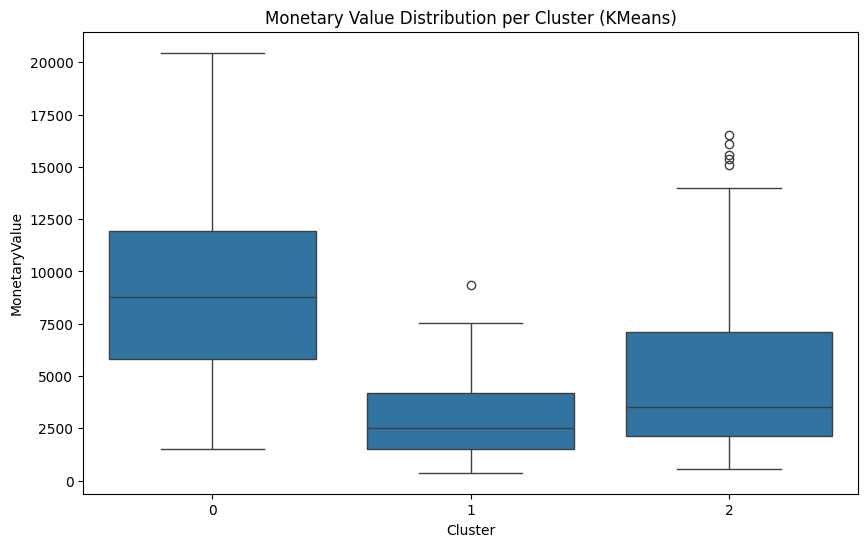

c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


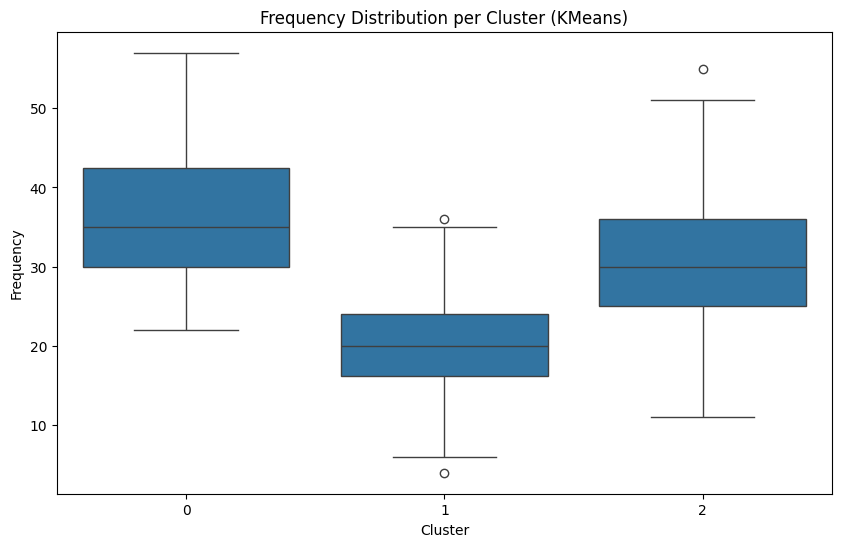

c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


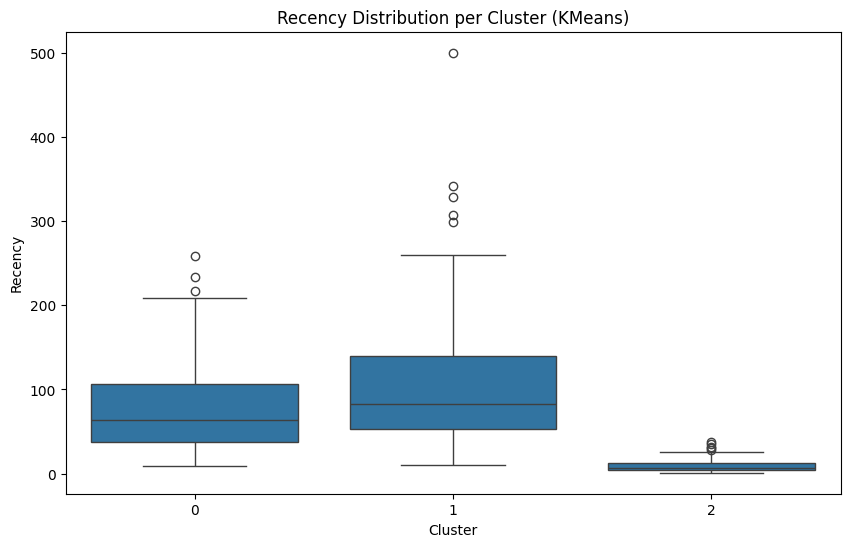

In [4]:
import pandas as pd
import numpy as np

# _________________________________________________
#Step 1: Load Data from Different Clustering Methods
# _________________________________________________
df_KMeans = pd.read_csv("RFM_Data_LogTransformed_Scaled_KMeans.CSV")
df_HC = pd.read_csv("RFM_Data_LogTransformed_Scaled_HC.csv")
df_DBSCAN = pd.read_csv("RFM_Data_LogTransformed_Scaled_DBSCAN.csv")

merged_df = (
    df_KMeans[['CustomerID', 'Cluster']].merge(df_HC[['CustomerID', 'Cluster_HC']], on = 'CustomerID').merge(df_DBSCAN[['CustomerID', 'Cluster_DBSCAN']], on = 'CustomerID')
)

merged_df.to_csv("ThreeMergedOnCustomerID.csv")
# print(merged_df)


# ________________________
# Step 2: Contigency Table
# ________________________

# KMeans vs HC
print("\n KMeans vs HC")
print(pd.crosstab(merged_df['Cluster'], merged_df['Cluster_HC']))
print()

# KMeans vs DBSCAN
print("\n KMeans vs DBSCAN")
print(pd.crosstab(merged_df['Cluster'], merged_df['Cluster_DBSCAN']))
print()

print("Hierarchical Clustering vs DBSCAN")
print(pd.crosstab(merged_df['Cluster_HC'], merged_df['Cluster_DBSCAN']))


# ___________________________________
# Now we scan the DBSCAN Noise points
# ___________________________________

noise_customers = merged_df[merged_df['Cluster_DBSCAN'] == -1]['CustomerID']
print("Number of noise customers: ", len(noise_customers))


#Load the original RFM CSV file for the customers

rfm_df = pd.read_csv("RFM_Data_LogTransformed_Scaled.csv")
noise_rfm = rfm_df[rfm_df['CustomerID'].isin(noise_customers)][
    ['CustomerID', 'Recency', 'Frequency', 'MonetaryValue']
]
noise_rfm.to_csv("customers_with_DBSCAN_Noise.csv")
print(noise_rfm.describe())
print()

print("Top Ten Noise Customers by MonetaryValue: ")
print(noise_rfm.sort_values(by = 'MonetaryValue', ascending=False).head(10))
print()


# Clustering
rfm_kmeans = rfm_df.merge(df_KMeans[['CustomerID', 'Cluster']], on = 'CustomerID')
# print("rfm_kmeans: ")
# print(rfm_kmeans)

cluster_profile = (
     rfm_kmeans.groupby('Cluster')[['Recency', 'Frequency', 'MonetaryValue']].mean().round(2).reset_index()    
 )

print("\n📊 Cluster Profiling (Average RFM per KMeans Cluster):")
print(cluster_profile)

# Add customer count for each cluster
cluster_profile['Count'] = rfm_kmeans['Cluster'].value_counts().sort_index().values

print("\n📈 Cluster Profiles Summary:")
print(cluster_profile)


def label_customer(row):
    if row['Cluster'] == 0:
        return "Loyal High Spenders"
    elif row['Cluster'] == 1:
        return "Regular Mid-Tier Buyers"
    elif row['Cluster'] == 2:
        return "At-Risk Low Spenders"
    else:
        return "New or Dormant Customers"

rfm_kmeans['Segment_Label'] = rfm_kmeans.apply(label_customer, axis=1)

# ============================
# 6. SAVE FINAL SEGMENTED DATA
# ============================
rfm_kmeans.to_csv("Final_Customer_Segments.csv", index=False)
print("\n✅ Final segmented file saved as 'Final_Customer_Segments.csv'.")

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(x='Cluster', y='MonetaryValue', data=rfm_kmeans)
plt.title('Monetary Value Distribution per Cluster (KMeans)')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='Cluster', y='Frequency', data=rfm_kmeans)
plt.title('Frequency Distribution per Cluster (KMeans)')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='Cluster', y='Recency', data=rfm_kmeans)
plt.title('Recency Distribution per Cluster (KMeans)')
plt.show()



In [15]:
# Python
# Pandas
# Numpy
# Datetime
# Seaborn
# Matplotlib
# Sklearn
# scipy

import sys
print("Python version: ", sys.version)
import pandas as pd
print("Pandas version: ", pd.__version__)
import numpy as np
print("Numpy version: ", np.__version__)

import seaborn as sns
print("Seaborn version: ", sns.__version__)
import matplotlib
print("Matplotlib Version: ", matplotlib.__version__)
import sklearn
print("Sklearn version: ", sklearn.__version__)
import scipy
import sklearn
print('SciPy version is: ', scipy.__version__)
print("SciKit-Learn version: ", sklearn.__version__)

Python version:  3.12.0 (tags/v3.12.0:0fb18b0, Oct  2 2023, 13:03:39) [MSC v.1935 64 bit (AMD64)]
Pandas version:  2.3.0
Numpy version:  1.26.4
Seaborn version:  0.13.0
Matplotlib Version:  3.8.0
Sklearn version:  1.7.1
SciPy version is:  1.14.1
SciKit-Learn version:  1.7.1
